In [1]:
import requests
from bs4 import BeautifulSoup
import re 
import pandas as pd 
import json
import time

In [2]:
def get_data_frames():
    '''
    This scrapes the site www.the-numbers.com for the years of 2009 until 2019
    '''
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    years = range(2009,2020)
    dfs = []
    for year in years:
        url = f'https://www.the-numbers.com/box-office-records/worldwide/all-movies/cumulative/released-in-{year}'
        time.sleep(2)
        html = requests.get(url, headers=headers) # avoid the 403
        yearly_df = pd.read_html(html.text)[1]
        yearly_df.dropna(inplace=True)
        yearly_df['year'] = year
        dfs.append(yearly_df)
    return dfs

frames = get_data_frames()
overall_df = pd.concat(frames, axis=0)

In [4]:
def clean_movie_names(dataframe):
    '''
    The movie names were coming back with some no ascii characters so this function cleans up 
    those characters and adds an apostrophe where those characters were located
    '''
    overall_df['clean_movie'] = overall_df.Movie.map(lambda x: x.replace("â", "'"))
    return overall_df

In [5]:
overall_df = clean_movie_names(overall_df)

In [10]:
def get_ratings(dataframe):
    '''
    This calls an api from omdbapi.com and returns a dictionary of values for the specified movies
    that were in the yearly gross profits from get_data_frames
    '''
    movie_rating_list = []
    for api_req,year in zip(dataframe.clean_movie, dataframe.year): 
        movie_name = f"http://www.omdbapi.com/?t={api_req}&y={year}&apikey=b213361e"
        try:
            movie_ratings = requests.get(movie_name).json()
            movie_rating_list.append(movie_ratings)
        except ValueError:
            print('Name did not work')
    return pd.DataFrame(movie_rating_list)


In [11]:
ratings_df = get_ratings(overall_df)

Name did not work


In [12]:
ratings_df

,Actors,Awards,BoxOffice,Country,DVD,Director,Error,Genre,Language,Metascore,...,Runtime,Title,Type,Website,Writer,Year,imdbID,imdbRating,imdbVotes,totalSeasons
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000",USA,22 Apr 2010,James Cameron,NaN,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,...,162 min,Avatar,movie,http://www.avatarmovie.com/,James Cameron,2009,tt0499549,7.8,"1,055,104",NaN
1,"Daniel Radcliffe, Michael Gambon, Dave Legeno,...",Nominated for 1 Oscar. Another 8 wins & 35 nom...,"$301,920,409","UK, USA",08 Dec 2009,David Yates,NaN,"Action, Adventure, Family, Fantasy, Mystery",English,78,...,153 min,Harry Potter and the Half-Blood Prince,movie,http://www.harrypotter.com/,"Steve Kloves (screenplay), J.K. Rowling (novel)",2009,tt0417741,7.6,"425,184",NaN
2,"Eunice Cho, Karen Disher, Harrison Fahn, Maile...",3 wins & 13 nominations.,"$124,605,432",USA,27 Oct 2009,"Carlos Saldanha, Mike Thurmeier(co-director)",NaN,"Animation, Adventure, Comedy, Family",English,50,...,94 min,Ice Age: Dawn of the Dinosaurs,movie,http://www.iceagemovie.com/,"Michael Berg (screenplay by), Peter Ackerman (...",2009,tt1080016,6.9,"206,824",NaN
3,"Shia LaBeouf, Megan Fox, Josh Duhamel, Tyrese ...",Nominated for 1 Oscar. Another 15 wins & 27 no...,"$402,076,689",USA,20 Oct 2009,Michael Bay,NaN,"Action, Adventure, Sci-Fi","English, Spanish",35,...,150 min,Transformers: Revenge of the Fallen,movie,http://www.TransformersMovie.com/,"Ehren Kruger, Roberto Orci, Alex Kurtzman",2009,tt1055369,6.0,"367,639",NaN
4,"John Cusack, Amanda Peet, Chiwetel Ejiofor, Th...",5 wins & 21 nominations.,"$166,112,167",USA,02 Mar 2010,Roland Emmerich,NaN,"Action, Adventure, Sci-Fi","English, French, Tibetan, Mandarin, Russian, H...",49,...,158 min,2012,movie,http://www.whowillsurvive2012.com/,"Roland Emmerich, Harald Kloser",2009,tt1190080,5.8,"331,033",NaN
5,"Edward Asner, Christopher Plummer, Jordan Naga...",Won 2 Oscars. Another 74 wins & 81 nominations.,"$292,979,556",USA,10 Nov 2009,"Pete Docter, Bob Peterson(co-director)",NaN,"Animation, Adventure, Comedy, Family",English,88,...,96 min,Up,movie,http://Disney.com/UP,"Pete Docter (story by), Bob Peterson (story by...",2009,tt1049413,8.2,"858,815",NaN
6,"Kristen Stewart, Christina Jastrzembska, Rober...",20 wins & 24 nominations.,"$296,593,070",USA,20 Mar 2010,Chris Weitz,NaN,"Adventure, Drama, Fantasy, Mystery, Romance","English, Italian",44,...,130 min,The Twilight Saga: New Moon,movie,http://www.newmoonthemovie.com/,"Melissa Rosenberg (screenplay), Stephenie Meye...",2009,tt1259571,4.7,"250,739",NaN
7,"Robert Downey Jr., Jude Law, Rachel McAdams, M...",Nominated for 2 Oscars. Another 10 wins & 27 n...,"$208,711,166","USA, Germany, UK",30 Mar 2010,Guy Ritchie,NaN,"Action, Adventure, Crime, Mystery, Thriller","English, French",57,...,128 min,Sherlock Holmes,movie,http://sherlock-holmes-movie.warnerbros.com/,"Michael Robert Johnson (screenplay), Anthony P...",2009,tt0988045,7.6,"553,313",NaN
8,"Alexia Aleman, Blaine Moir, Robin Sydney, Step...",N/A,N/A,USA,N/A,"Josh Martinez, Joshua Martinez",NaN,"Short, Drama, Fantasy, Sci-Fi",English,N/A,...,3 min,Angels,movie,N/A,"Alexia Aleman (story), Alexia Aleman",2009,tt1521673,8.4,5,NaN
9,"Bradley Cooper, Ed Helms, Zach Galifianakis, J...",Won 1 Golden Globe. Another 12 wins & 25 nomin...,"$277,313,371","USA, Germany",15 Dec 2009,Todd Phillips,NaN,Comedy,English,73,...,100 min,The Hangover,movie,http://hangovermovie.warnerbros.com/,"Jon Lucas, Scott Moore",2009,tt1119646,7.7,"676,552",NaN


In [13]:
overall_df

,Rank,Movie,Worldwide Box Office,Domestic Box Office,International Box Office,DomesticShare,year,clean_movie
0,1,Avatar,"$2,789,705,275","$760,507,625","$2,029,197,650",27.26%,2009,Avatar
1,2,Harry Potter and the Half-Blood Prince,"$935,213,767","$302,089,278","$633,124,489",32.30%,2009,Harry Potter and the Half-Blood Prince
2,3,Ice Age: Dawn of the Dinosaurs,"$859,701,857","$196,573,705","$663,128,152",22.87%,2009,Ice Age: Dawn of the Dinosaurs
3,4,Transformers: Revenge of the Fallen,"$836,519,699","$402,111,870","$434,407,829",48.07%,2009,Transformers: Revenge of the Fallen
4,5,2012,"$757,677,748","$166,112,167","$591,565,581",21.92%,2009,2012
5,6,Up,"$731,463,377","$293,004,164","$438,459,213",40.06%,2009,Up
6,7,The Twilight Saga: New Moon,"$687,557,727","$296,623,634","$390,934,093",43.14%,2009,The Twilight Saga: New Moon
7,8,Sherlock Holmes,"$498,438,212","$209,028,679","$289,409,533",41.94%,2009,Sherlock Holmes
8,9,Angels & Demons,"$490,875,846","$133,375,846","$357,500,000",27.17%,2009,Angels & Demons
9,10,The Hangover,"$465,764,086","$277,322,503","$188,441,583",59.54%,2009,The Hangover


In [20]:
def get_tomato_score(row):
    try:
        tomato_val = [x.get('Value') for x in row if x.get('Source') == 'Rotten Tomatoes'][0]
        tomato_val = tomato_val.replace('%','')
        return int(tomato_val)
    except:
        return (None)

In [15]:
def imdb_clean(row):
    try:
        return float(row) * 10
    except:
        return(None)

In [16]:
def get_meta_score(row):
    try:
        return int(row)
    except:
        return(None)

In [21]:
ratings_df['Rotten_Score'] = ratings_df.Ratings.map(get_tomato_score)
ratings_df['Metacritic_Score'] = ratings_df.Metascore.map(get_meta_score)
ratings_df['Imdb_Score'] = ratings_df.imdbRating.map(imdb_clean)

In [22]:
joining_df = ratings_df[['Title','Rotten_Score','Metacritic_Score','Imdb_Score']].set_index('Title')

In [25]:
joining_df

,Rotten_Score,Metacritic_Score,Imdb_Score
Title,,,
Avatar,82.0,83.0,78.0
Harry Potter and the Half-Blood Prince,83.0,78.0,76.0
Ice Age: Dawn of the Dinosaurs,46.0,50.0,69.0
Transformers: Revenge of the Fallen,20.0,35.0,60.0
2012,39.0,49.0,58.0
Up,98.0,88.0,82.0
The Twilight Saga: New Moon,28.0,44.0,47.0
Sherlock Holmes,69.0,57.0,76.0
Angels,NaN,NaN,84.0


In [27]:
joined_df = overall_df[['Worldwide Box Office','Domestic Box Office','International Box Office',
                               'DomesticShare','year','clean_movie']].set_index('clean_movie')

In [34]:
final_df = joined_df.join(joining_df,on='clean_movie',how='inner')

In [35]:
final_df = final_df.dropna()

In [36]:
final_df

,Worldwide Box Office,Domestic Box Office,International Box Office,DomesticShare,year,Rotten_Score,Metacritic_Score,Imdb_Score
clean_movie,,,,,,,,
Avatar,"$2,789,705,275","$760,507,625","$2,029,197,650",27.26%,2009,82.0,83.0,78.0
Harry Potter and the Half-Blood Prince,"$935,213,767","$302,089,278","$633,124,489",32.30%,2009,83.0,78.0,76.0
Ice Age: Dawn of the Dinosaurs,"$859,701,857","$196,573,705","$663,128,152",22.87%,2009,46.0,50.0,69.0
Transformers: Revenge of the Fallen,"$836,519,699","$402,111,870","$434,407,829",48.07%,2009,20.0,35.0,60.0
2012,"$757,677,748","$166,112,167","$591,565,581",21.92%,2009,39.0,49.0,58.0
Up,"$731,463,377","$293,004,164","$438,459,213",40.06%,2009,98.0,88.0,82.0
The Twilight Saga: New Moon,"$687,557,727","$296,623,634","$390,934,093",43.14%,2009,28.0,44.0,47.0
Sherlock Holmes,"$498,438,212","$209,028,679","$289,409,533",41.94%,2009,69.0,57.0,76.0
The Hangover,"$465,764,086","$277,322,503","$188,441,583",59.54%,2009,78.0,73.0,77.0


In [40]:
WBOlistvalues =[]
for value in final_df['Worldwide Box Office']:
    WBOlistvalues.append(int(value.replace('$','').replace(',','')))
print(len(WBOlistvalues))

797


In [43]:
DBOlistvalues =[]
for value in final_df['Domestic Box Office']:
    DBOlistvalues.append(int(value.replace('$','').replace(',','')))
print(len(DBOlistvalues))

797


In [39]:
IBOlistvalues =[]
for value in final_df['International Box Office']:
    IBOlistvalues.append(int(value.replace('$','').replace(",",'')))
print(len(IBOlistvalues))

797


In [45]:
final_df['Worldwide Box Office'] = WBOlistvalues
final_df['Domestic Box Office'] = DBOlistvalues
final_df['International Box Office'] = IBOlistvalues


In [ ]:
DS = final_df['Domestic Box Office'][0] / final_df['Worldwide Box Office'][0]
DS

In [48]:
final_df['Worldwide Box Office'].mean()

281204627.28230864

In [49]:
final_df['Domestic Box Office'].mean()

108718815.21455458

In [50]:
final_df['International Box Office'].mean()

172485812.0677541

In [55]:
final_df['Rotten_Score'].mean()

55.59723964868256

In [56]:
final_df['Imdb_Score'].mean()

65.27603513174404

In [57]:
final_df['Metacritic_Score'].mean()

54.429109159347554

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5cf067b550>,
      dtype=object)

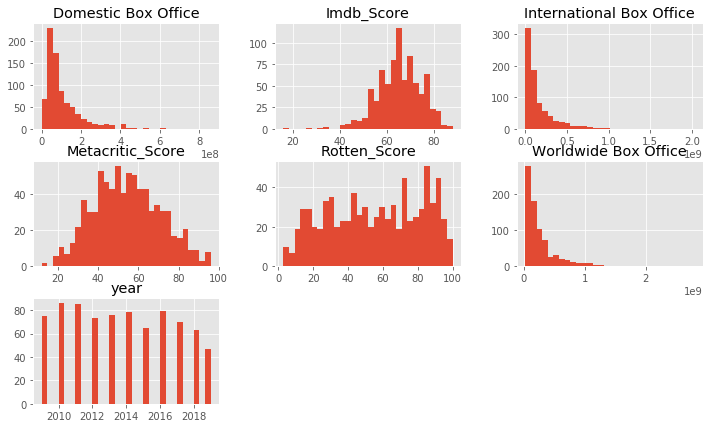

In [54]:
final_df.hist(figsize=(12,7),bins=30)

In [70]:
for year in range(2009,2020):
    year = final_df[final_df['year']==year]

In [71]:
year

,Worldwide Box Office,Domestic Box Office,International Box Office,DomesticShare,year,Rotten_Score,Metacritic_Score,Imdb_Score
clean_movie,,,,,,,,
Avengers: Endgame,2795409509,858367305,1937042204,30.71%,2019,94.0,78.0,86.0
The Lion King,1599378019,529478019,1069900000,33.11%,2019,53.0,55.0,71.0
Captain Marvel,1126129839,426829839,699300000,37.90%,2019,78.0,64.0,70.0
Toy Story 4,1053342828,431842828,621500000,41.00%,2019,97.0,84.0,82.0
Fast & Furious Presents: Hobbs & Shaw,722355509,164598080,557757429,22.79%,2019,66.0,60.0,68.0
How to Train Your Dragon: The Hidden World,519235419,160799505,358435914,30.97%,2019,91.0,71.0,75.0
The Secret Life of Pets 2,425196237,158118645,267077592,37.19%,2019,60.0,55.0,65.0
Alita: Battle Angel,402971268,85710210,317261058,21.27%,2019,60.0,53.0,74.0
Godzilla: King of the Monsters,383299915,110500138,272799777,28.83%,2019,41.0,48.0,62.0
